## Multi-outputs example

This notebook builds a CNN to classifiy items with multiple categories using multi-output classification.

This is different from multi-label classification, which still has one output node / fully-connected head in the NN to output multiple class labels.

In mutli-output classification, we have at least 2 fully-connected heads; each performing a specific classification task

## 1. Load libs

In [1]:
from keras.models import Model
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import cv2
from imutils import paths
import os
from cnn_utils import load_fashionnet_dataset, load_fashionnet_test_dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## 2. Building model

In [2]:
def category_branch(inputs, num_categories, final_act="softmax", chan_dim=-1):
    # utilize a lambda layer to convert the 3 channel input to a
    # grayscale representation
    x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
    
    # CONV => RELU => POOL
    x = Conv2D(32, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)
    
    # (CONV => RELU) * 2 => POOL
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # (CONV => RELU) * 2=> POOL
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # define fully-connected layer for different categories
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_categories)(x)
    x = Activation(final_act, name="category_output")(x)
    
    return x

In [3]:
def colour_branch(inputs, num_colours, final_act="softmax", chan_dim=-1):
    """
    Builds the branch of network that classifies based on colour features
    """
    
    # CONV => RELU => POOL
    x = Conv2D(16, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)
    
    # CONV => RELU => POOL
    x = Conv2D(32, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # CONV => RELU => POOL
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # define fully-connected layer that outputs different colour predictions
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_colours)(x)
    x = Activation(final_act, name="colour_output")(x)
    
    return x

In [4]:
def build_model(width, height, num_categories, num_colours, final_act="softmax"):
    """
    Builds final model using above 2 branches
    """
    
    input_shape = (width, height, 3)
    chan_dim = -1
    
    inputs = Input(shape=input_shape)
    
    category = category_branch(inputs, num_categories, final_act, chan_dim)
    
    colour = colour_branch(inputs, num_colours, final_act, chan_dim)
    
    model = Model(
        inputs=inputs,
        outputs=[category, colour],
        name="fashionnet"
    )
    
    return model

## 3. Loading dataset

For this tutorial, we are using a dataset of fashion items grouped into its respective categories and colours.

For example: `black_jeans`, `blue_shoes`

Each directory has the following number of samples:
* black_jeans => 345
* black_shoes => 361
* blue_dress => 389
* blue_jeans => 359
* blue_shirt => 372
* red_dress => 383
* red_shirt => 355

We will load the dataset into memory, one category at a time, and for each image, resize it and convert channel ordering from BGR to RGB

(96, 96, 3)


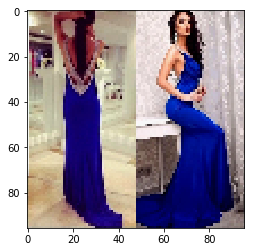

<class 'numpy.ndarray'>
b'dress'
b'blue'


In [5]:
# Loading dataset
seed = 7
np.random.seed(seed)

data, colourLabels, categoryLabels = load_fashionnet_dataset()

# examining the dataset
print(data[0].shape)
plt.imshow(array_to_img(data[0]))
plt.show()
print(type(data[0]))
print(categoryLabels[0])
print(colourLabels[0])

In [6]:
# normalize the data by making values in range 0-1
data2 = data / 255.0
print("MIN: {}, MAX: {}".format(data2.min(), data2.max()))

print(categoryLabels.shape)
print(categoryLabels[0])

# encode class values as integers then one-hot encode
encoder = LabelEncoder()
encoder.fit(categoryLabels)
categoryClasses = encoder.classes_
print(categoryClasses)
encoded = encoder.transform(categoryLabels)
categoryLB = to_categorical(encoded)
print(categoryLB.shape)
print(categoryLB[0])

print(colourLabels.shape)
print(colourLabels[0])

encoder = LabelEncoder()
encoder.fit(colourLabels)
colourClasses = encoder.classes_
print(colourClasses)
encoded = encoder.transform(colourLabels)
colourLB = to_categorical(encoded)
print(colourLB.shape)
print(colourLB[0])

MIN: 0.0, MAX: 1.0
(2521,)
b'dress'
[b'dress' b'jeans' b'shirt' b'shoes']
(2521, 4)
[1. 0. 0. 0.]
(2521,)
b'blue'
[b'black' b'blue' b'red']
(2521, 3)
[0. 1. 0.]


In [7]:
Xtrain, Xtest, trainCategoryY, testCategoryY, trainColourY, testColourY = train_test_split(
    data2, categoryLB, colourLB, test_size=0.2, random_state=seed)
print(Xtrain.shape)
print(Xtest.shape)
print(trainCategoryY.shape)
print(testCategoryY.shape)
print(trainColourY.shape)
print(testColourY.shape)

(2016, 96, 96, 3)
(505, 96, 96, 3)
(2016, 4)
(505, 4)
(2016, 3)
(505, 3)


## 4. Building the model

In [8]:
BATCH_SIZE = 32
EPOCHS = 25 # should be higher such as 50
INIT_LR = 1e-3

model = build_model(96, 
                    96, 
                    num_categories=categoryLB.shape[1], 
                    num_colours=colourLB.shape[1], 
                    final_act="softmax")

losses = {
    "category_output": "categorical_crossentropy",
    "colour_output": "categorical_crossentropy"
}

loss_weights = {
    "category_output": 1.0,
    "colour_output": 1.0
}

opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)

model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights, metrics=['acc'])

H = model.fit(Xtrain, {"category_output": trainCategoryY, "colour_output": trainColourY}, 
              validation_data=(Xtest, {"category_output": testCategoryY, "colour_output": testColourY}), 
             epochs=EPOCHS, batch_size=BATCH_SIZE)

# Save model
model.save("fashionnet.model")

Train on 2016 samples, validate on 505 samples
Epoch 1/25
2016/2016 [==============================] - 204s 101ms/step - loss: 0.8974 - category_output_loss: 0.5624 - colour_output_loss: 0.3350 - category_output_acc: 0.8304 - colour_output_acc: 0.8725 - val_loss: 0.5267 - val_category_output_loss: 0.3883 - val_colour_output_loss: 0.1384 - val_category_output_acc: 0.8871 - val_colour_output_acc: 0.9446
Epoch 2/25
2016/2016 [==============================] - 187s 93ms/step - loss: 0.3882 - category_output_loss: 0.2774 - colour_output_loss: 0.1109 - category_output_acc: 0.9043 - colour_output_acc: 0.9633 - val_loss: 0.4125 - val_category_output_loss: 0.3095 - val_colour_output_loss: 0.1029 - val_category_output_acc: 0.9287 - val_colour_output_acc: 0.9624
Epoch 3/25
2016/2016 [==============================] - 188s 93ms/step - loss: 0.2730 - category_output_loss: 0.1987 - colour_output_loss: 0.0742 - category_output_acc: 0.9350 - colour_output_acc: 0.9712 - val_loss: 0.4345 - val_category_

Epoch 24/25
2016/2016 [==============================] - 190s 94ms/step - loss: 0.0507 - category_output_loss: 0.0332 - colour_output_loss: 0.0175 - category_output_acc: 0.9906 - colour_output_acc: 0.9945 - val_loss: 0.3155 - val_category_output_loss: 0.2044 - val_colour_output_loss: 0.1111 - val_category_output_acc: 0.9604 - val_colour_output_acc: 0.9782
Epoch 25/25
2016/2016 [==============================] - 189s 94ms/step - loss: 0.0452 - category_output_loss: 0.0190 - colour_output_loss: 0.0262 - category_output_acc: 0.9945 - colour_output_acc: 0.9906 - val_loss: 1.0353 - val_category_output_loss: 0.2258 - val_colour_output_loss: 0.8094 - val_category_output_acc: 0.9446 - val_colour_output_acc: 0.8812


## 5. Plotting the loss/accuracy

From the plots below, it can be seen that the total loss and total validation loss will converge when the model is trained for more epochs.



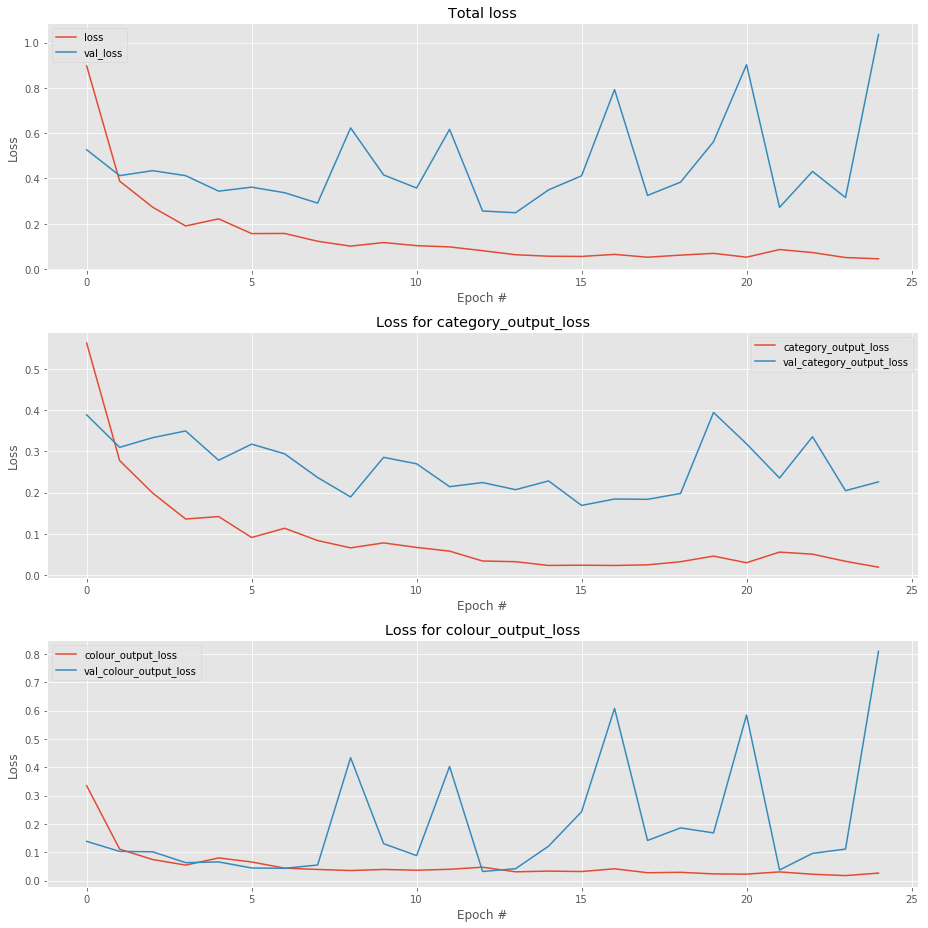

In [10]:
# Plot the losses
lossNames = ["loss", "category_output_loss", "colour_output_loss"]

plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
    ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l], label="val_" + l)
    ax[i].legend()

plt.tight_layout()

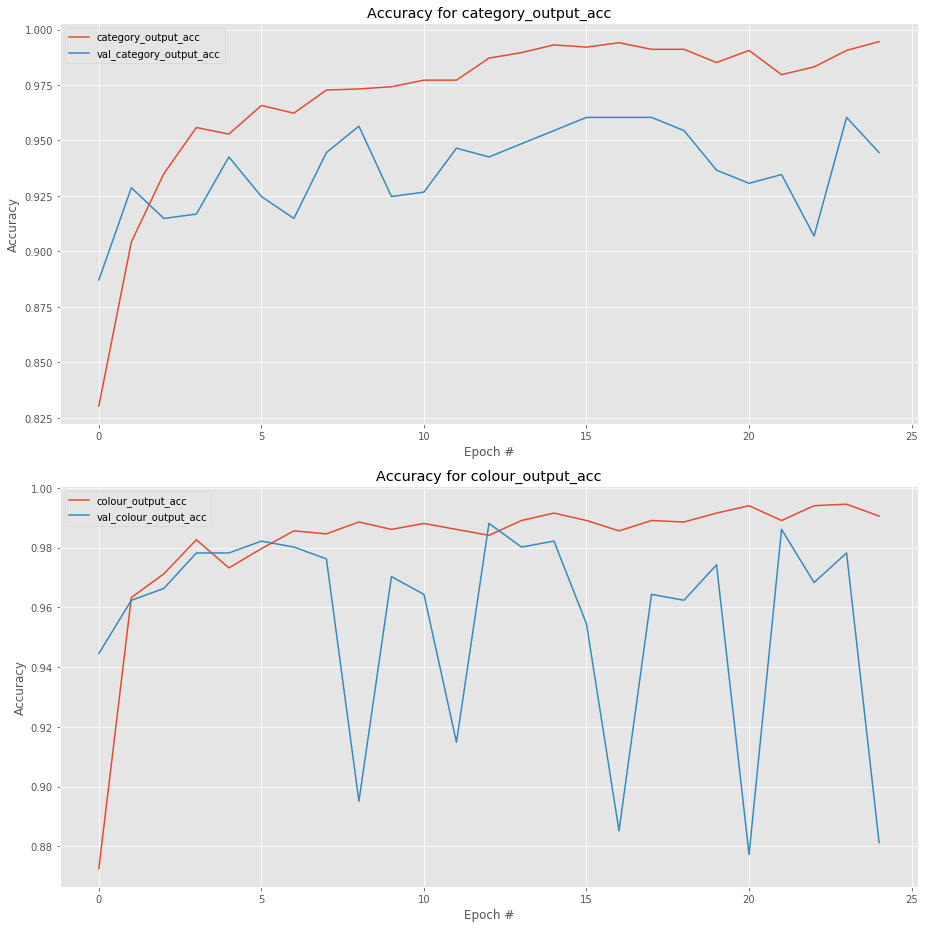

In [11]:
# Plot the accuracies
accuracyNames = ["category_output_acc", "colour_output_acc"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(2, 1, figsize=(13, 13))

for (i, l) in enumerate(accuracyNames):
    # plot the accuracies for both the training and validation data
    ax[i].set_title("Accuracy for {}".format(l))
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Accuracy")
    ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
    ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l], label="val_" + l)
    ax[i].legend()

plt.tight_layout()

## 6. Make predictions with test dataset

To make a prediction with the test dataset, we need to convert the test data sample using the same methods used for 
processing the training dataset above

In [13]:
model = load_model("fashionnet.model", custom_objects={"tf": tf})

test_dataset, test_labels = load_fashionnet_test_dataset()

for idx, label in enumerate(test_labels):
    print("Classifying image: {}".format(label))
    img = test_dataset[idx]
    img = img.astype("float32")
    img /= 255.0
    img = np.expand_dims(img, 0)
    (categoryProb, colourProb) = model.predict(img)
    categoryIdx = categoryProb[0].argmax()
    colourIdx = colourProb[0].argmax()
    category = categoryClasses[categoryIdx]
    colour = colourClasses[colourIdx]
    proba = categoryProb[0][categoryIdx] * 100
    probb = colourProb[0][colourIdx] * 100
    print("Predicted category: {} prob: {:.2f}%, colour: {} prob: {:.2f}%".format(category, proba, colour, probb))
    print()

Classifying image: b'datasets/fashionnet_examples/black_dress.jpg'
Predicted category: b'dress' prob: 96.52%, colour: b'black' prob: 99.79%

Classifying image: b'datasets/fashionnet_examples/black_jeans.jpg'
Predicted category: b'jeans' prob: 100.00%, colour: b'black' prob: 99.07%

Classifying image: b'datasets/fashionnet_examples/blue_shoes.jpg'
Predicted category: b'shoes' prob: 100.00%, colour: b'blue' prob: 99.98%

Classifying image: b'datasets/fashionnet_examples/red_shirt.jpg'
Predicted category: b'shirt' prob: 100.00%, colour: b'red' prob: 100.00%

Classifying image: b'datasets/fashionnet_examples/red_shoes.jpg'
Predicted category: b'shoes' prob: 69.42%, colour: b'black' prob: 100.00%



## Extensions

* Run the training epoch longer and plot the loss/accuracies

* Use LabelBinarizer instead of converting to integers and then one-hot encode

* Saving the model and binarizers (?)

* Experiment with different pixel scaling strategies and see if that makes a difference